---
# Modelling hippocampal neurons of animals navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu
---

##### Outline
Rat simulation:
- Motion model (RatInABox)
- Environment design (Blender)
- Simulated rat vision (ratvision)

Vision autoencoder

Hippocampus model (RNN):
- RNN definition
- Data loading
- Training

Hidden state representations analysis:
- Rate maps
- Polar maps
- Quantitive metrics
- Comparison with real data

---
## **Part 4: Extracting Neural Representations from an RNN**
In this notebook, we will write code to extract representations from the **RNN hidden states**. These includes:
- Rate maps
- Polar maps
- Quantitative metrics
- Comparison with _in vivo_ data

Before starting this notebook, make sure you have:
- trajectory data from part 1, including speed and rotational speed
- embedded vision data from the Vision Autoencoder we trained in part 2


### **0. Install and import dependencies**

In [1]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install matplotlib
!pip install scipy

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   --- ----------------------------------- 21.0/216.1 MB 102.0 MB/s eta 0:00:02
   ------- ------------------------------- 44.3/216.1 MB 108.5 MB/s eta 0:00:02
   ------------ -------------------------- 67.9/216.1 MB 108.2 MB/s eta 0:00:02
   ---------------- ---------------------- 92.3/216.1 MB 109.0 MB/s eta 0:00:02
   -------------------- ----------------- 115.1/216.1 MB 109.7 MB/s eta 0:00:01
   ------------------------ ------------- 138.9/216.1 MB 109.6 MB/s eta 0:00:01
   ---------------------------- --------- 161.5/216.1 MB 109.7 MB/s eta 0:00:01
   -------------------------------- ----- 185.9/216.1 MB 111.0 MB/s eta 0:00:01
   ------------------------------------ - 209.2/216.1 MB 111.4 MB/s eta 0:00:01
   -------------------------------------  216.0/216.1 MB 111.4 MB/s eta 0:00:01
   -------------------------------------- 216.1/216.1 MB 102.3 M

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### **1. Load test data and trained RNN**

In the first step, we will define the RNN in Part 3 of this tutorial and load the trained weights. We will also need the test embeddings and auxiliary variables, with which we will use to compute the rate maps.

In [2]:
# Run this cell, do not modify it.

def create_multiple_subsampling(data, stride, is_velocity=False):
    new_length = data.shape[0]//stride if not is_velocity else data.shape[0]//stride-1
    data_multisubs = np.zeros(
        (stride, new_length, data.shape[1]),
        dtype=np.float32
    )
    for start_idx in range(stride):
        if is_velocity:
            if start_idx < stride-1:
                data_multisubs[start_idx] = data[start_idx+1:start_idx-stride+1].reshape(
                    new_length, stride, -1
                ).sum(axis=1)
            else:
                data_multisubs[start_idx] = data[start_idx+1:].reshape(
                    new_length, stride, -1
                ).sum(axis=1)
        else:
            data_multisubs[start_idx] = data[start_idx::stride]
    return data_multisubs

class RNNCell(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, input_bias, hidden_bias):
        super(RNNCell, self).__init__()

        self.in2hidden = torch.nn.Linear(n_inputs, n_hidden, bias=input_bias)
        self.hidden2hidden = torch.nn.Linear(n_hidden, n_hidden, bias=hidden_bias)

        self.activation_fn = torch.nn.Sigmoid()

    def forward(self, x, hidden):
        igates = self.in2hidden(x)
        hgates = self.hidden2hidden(hidden)
        return self.activation_fn(igates + hgates)


class RNNModule(torch.nn.Module):
    def __init__(
        self, device, n_inputs, n_hidden,
        input_bias, hidden_bias
    ):
        super(RNNModule, self).__init__()

        self.rnn_cell = RNNCell(n_inputs, n_hidden, input_bias, hidden_bias)
        self.n_hidden = n_hidden

        self.device = device

    def forward(self, x, hidden=None):
        # x: [BATCH SIZE, TIME, N_FEATURES]
        # hidden: [BATCH SIZE, N_HIDDEN]
        
        output = torch.zeros(x.shape[0], x.shape[1], self.n_hidden).to(self.device)

        if hidden is None:
            h_out = torch.zeros(x.shape[0], self.n_hidden) # initialize hidden state
            h_out = h_out.to(self.device)
        else:
            h_out = hidden

        window_size = x.shape[1]

        # loop over time
        for t in range(window_size):
            x_t = x[:,t,...]
            h_out = self.rnn_cell(x_t, h_out)
            output[:,t,...] = h_out

        # return all outputs, and the last hidden state
        return output, h_out

class PredictiveRNN(torch.nn.Module):
    def __init__(self,
        device, n_inputs, n_hidden, n_outputs, bias=False
    ):
        super().__init__()

        self.rnn = RNNModule(
            device, n_inputs, n_hidden,
            input_bias=bias, hidden_bias=bias
        )

        self.linear_layer = torch.nn.Linear(n_hidden, n_outputs, bias=bias)

    def inputs2hidden(self, inputs, hidden):
        """ Encodes the input tensor into a latent representation.

        Args:
            x: [BATCH SIZE, TIME, CHANNELS, HEIGHT, WIDTH]
        """
        
        if hidden is not None:
            return self.rnn(inputs, hidden[None, ...])[0]
        else:
            return self.rnn(inputs)[0]

    def hidden2outputs(self, hidden):
        return self.linear_layer(hidden)
    
    def forward(self, inputs, hidden=None):
        hidden_new = self.inputs2hidden(inputs, hidden)

        output = self.hidden2outputs(hidden_new)

        return output, hidden_new[:,-1,:]

class SensoryDataset(torch.utils.data.Dataset):
    def __init__(self, embs, vels, rot_vels, pos, hds, tsteps=9):
        '''
        The initialisation function for the SensoryDataset class.
        At initialisation, all embeddings are converted to tensors.
        Args:
            embs: The visual embeddings of shape (N, T, D)
            vels: The speed signals of shape (N, T-1, 1)
            rot_vels: The rotational velocities of shape (N, T-1, 1)
            pos: The positions of shape (N, T, 2)
            hds: The headings of shape (N, T, 1)
            tsteps: The number of time steps for each batch.
                By default, this is set to 9 i.e. we use the sensory input from steps 1 to 9          
        '''
        self.embs = torch.from_numpy(embs)
        self.vels = torch.from_numpy(vels)
        self.rot_vels = torch.from_numpy(rot_vels)
        self.pos = torch.from_numpy(pos)
        self.hds = torch.from_numpy(hds)
        
        self.tsteps = tsteps
    
    def __len__(self):
        # COMPLETE THE CODE HERE: how many samples are in the dataset?
        return self.embs.shape[1] // self.tsteps - 1
    
    def __getitem__(self, idx):
        '''
        This function returns a batch of sensory inputs and the corresponding future sensory inputs.
        Args:
            idx: The index of the sample to return. idx will be automatically generated by the DataLoader.
        Returns:
        
        '''
        vels, rot_vels, pos, hds, embs_labels = [], [], [], [], []

        start_idx, end_idx = idx*self.tsteps, (idx + 1)*self.tsteps

        embs = self.embs[:, start_idx:end_idx]

        vels = self.vels[:, start_idx:end_idx]
        rot_vels = self.rot_vels[:, start_idx:end_idx]
        pos = self.pos[:, start_idx:end_idx]
        hds = self.hds[:, start_idx:end_idx]

        embs_labels = self.embs[:, start_idx+1 : end_idx+1]
        
        return embs, vels, rot_vels, pos, hds, embs_labels
    

In [4]:
# let's load the test data and process it into a dataloader, just like we did in the last part.

STRIDE = 10
d = './data/adult'
trial_paths = sorted([p for p in Path(d).iterdir() if 'exp' in p.name])

repr_embeddings = []
repr_vel, repr_rotvel, repr_pos, repr_hds = [], [], [], []

for idx in range(20, len(trial_paths)):
    tp = trial_paths[idx]
    repr_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    repr_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    repr_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )
    repr_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    repr_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )

repr_embeddings = np.concatenate(repr_embeddings, axis=0)
repr_vel = np.concatenate(repr_vel, axis=0)
repr_rotvel = np.concatenate(repr_rotvel, axis=0)
repr_pos = np.concatenate(repr_pos, axis=0)
repr_hds = np.concatenate(repr_hds, axis=0)

dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        repr_embeddings, repr_vel, repr_rotvel, repr_pos, repr_hds
    ), shuffle=False
)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\adult\\exp_dim0.635_fps10_s720_seed21\\vision_embeddings.npy'

In [5]:
# let's re-define the PredictiveRNN model, just like we did in the last part
# and load the trained weights

visual_embedding_dim = repr_embeddings.shape[-1]
motion_signal_dim = repr_vel.shape[-1] + repr_rotvel.shape[-1]
trained_rnn_weights ='./rnn.pth'

rnn = PredictiveRNN(
    DEVICE,
    n_inputs=visual_embedding_dim + motion_signal_dim,
    n_hidden=500,
    n_outputs=visual_embedding_dim
).to(DEVICE)

loss_fn = torch.nn.L1Loss()

# load the trained weights
rnn.load_state_dict(torch.load(trained_rnn_weights, map_location=DEVICE))

<All keys matched successfully>

### **2. Get hidden states from trained RNN**

We had written a function named ```evaluate_rnn()```, when the parameter ```for_ratemaps``` is set to ```True```, the function will return a dictionary containing the hidden staes, positions, velocities, etc. at each step for the convenience of our analysis.

In [ ]:
from utils import evaluate_rnn
d = evaluate_rnn(DEVICE, rnn, dataloader, loss_fn, for_ratemaps=True)

hidden_states = d['hidden_states']
hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])
positions = d['positions']
positions = positions.reshape(-1, positions.shape[-1])
head_directions = d['head_directions']
head_directions = head_directions.reshape(-1, head_directions.shape[-1])

hidden_states.shape, positions.shape, head_directions.shape

((42660, 500), (42660, 2), (42660, 1))

### **3. Rate maps**

The **rate map** of a neuron is essentially the average activity of a neuron across an environment. This is, by design, a continuous distribution.

Computationally, this requires us to discritise the environment into smallers 'bins', then compute the average activity at each small bin. The function below computes such average.

In [ ]:
from scipy.ndimage import gaussian_filter

# The following function discritise the environment into smaller bins.

def bin_data(data, n_bins, limits, weights=[]):
    """
    Creates an N-dimensional histogram of data using n_bins between limits.
    If weights is provided, it creates a weighted histogram.
    
    Args:
        data: The data to be binned of shape (n_samples, n_dim).
        n_bins: The number of bins for each dimension.
        limits (list of tuples): The lower and upper limits for each dimension.
        weights: 1D array-like, optional
            The weights for the counts in the histogram.
    
    Returns:
        binned_data: The N-dimensional histogram of data.
    """
    
    n_dim = data.shape[-1]
    if np.size(n_bins) < n_dim:
        n_bins = np.repeat(n_bins, n_dim)
    
    bins = []
    if n_dim == 1:
        bins.append(np.linspace(limits[0], limits[1], n_bins+1))
    else:
        for i in range(n_dim):
            bins.append(np.linspace(limits[i][0], limits[i][1], n_bins[i]+1))
        
    if len(weights) == 0:
        hst = np.histogramdd(data, bins=bins)
    else:
        hst = np.histogramdd(data, bins=bins, weights=weights, density=False)

    return hst[0]


# The following function calculates the average activity of each such bin, that is, the rate map.

def compute_rate_maps(
    hidden_states:np.array, pos:np.array, sigma:float,
    limits=[(0, 0.635),(0, 0.635)], n_bins:int=25
):
    """
    Calculates the smooth rate map for each neuron based on the given hidden states and trajectory.

    Args:
        hidden_states (np.array): (samples, n_hidden) Array of hidden states for each neuron.
        pos (np.array): (samples, 2) Array of (x,y) positions.
        sigma (float): Standard deviation of the Gaussian filter.
        limits (list): Lower and upper limits of the positions.
        n_bins (float): Number of bins for the positions.

    Returns:
        rate_maps (np.array): Smoothed rate maps for each neuron of shape (n_hidden, n_bins, n_bins).
        occupancy_smoothed (np.array): Smoothed occupancy map of shape (n_bins, n_bins).
    """
    
    occupancy = bin_data(pos, n_bins=n_bins, limits=limits)
    if sigma > 0:
        occupancy = gaussian_filter(occupancy,sigma)

    n_cells = hidden_states.shape[1]
    rate_maps = np.empty(shape=(n_cells,occupancy.shape[0],occupancy.shape[1]))
    for i in range(n_cells):
        activations = bin_data(pos, n_bins=n_bins, limits=limits, weights=hidden_states[:,i])
        if sigma > 0: 
            activations = gaussian_filter(activations, sigma)
        rate_maps[i,:,:] = np.divide(
            activations, occupancy, where=occupancy!=0,
            out=np.nan*np.ones_like(activations)
        )
    
    # flip y and swap x and y coordinates so that they appear correctly in the image
    rate_maps = np.flip(rate_maps, axis=-1)
    rate_maps = np.transpose(rate_maps, (0, 2, 1))

    return rate_maps, occupancy

In the real brain, neuron firings are stochastic. This means there is a lot of noise in the process, and the average activity of each bin is a crude (but unbiased) estimate of the real tuning curve, depending on the amount of data provided.

Often, we make the assumption that a neuron's activity do not change too much in neighbouring bins. To make our rate maps look smoother, it is customary to apply **Gaussian smoothing** to the rate maps. This is easily achievable with packages.

In [8]:
rate_maps, occupancy = compute_rate_maps(hidden_states, positions, sigma=0)

rate_maps_smooth, occupancy_smooth = compute_rate_maps(hidden_states, positions, sigma=1.5)

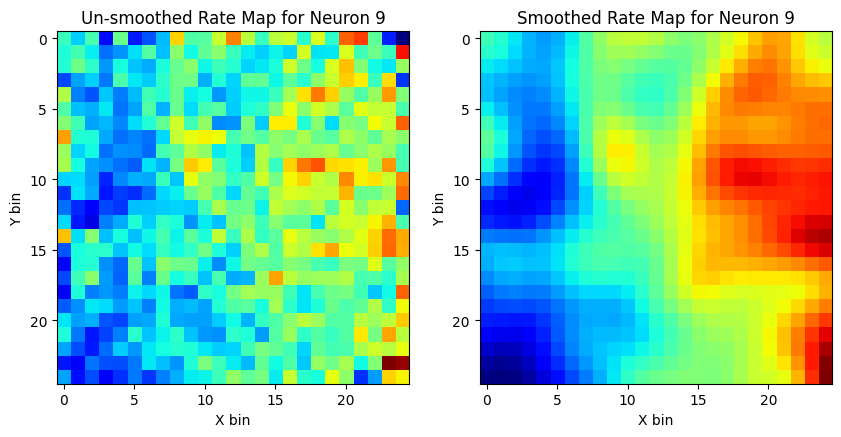

In [12]:
n = 9

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(rate_maps[n], cmap='jet')
axs[0].set_title(f'Un-smoothed Rate Map for Neuron {n}')
axs[0].set_xlabel('X bin')
axs[0].set_ylabel('Y bin')

axs[1].imshow(rate_maps_smooth[n], cmap='jet')
axs[1].set_title(f'Smoothed Rate Map for Neuron {n}')
axs[1].set_xlabel('X bin')
axs[1].set_ylabel('Y bin')

plt.show()

In [ ]:
# optional: we can plot 100 rate maps at once here

### **4. Polar maps**

Comparable to rate maps, the **polar maps** show how a neuron fires when it is tuned to a specific angle (the head direction tuning).

**Note**: In this notebook, we have used the term _head direction_ and _theta_ interchangeably.

In [ ]:
def compute_polar_maps(latent_activity: np.array, head_directions: np.array, n_samples_thet: int):
    """
    Calculate the polar data for the given latent data.

    Args:
    latent_activity (np.array): (n_samples, n_units) The latent data, neurons' activities.
    head_directions (np.array): (n_samples,) The theta angles corresponding to each sample in radians.
    n_samples_thet (int): Number of bins in the theta direction (default is 60, i.e. 6 degrees).

    Returns:
    polar_maps (np.array): (n_units, n_samples_thet) Array of polar maps, one for each unit.
    pm_std (np.array): (n_units, n_samples_thet) Array of standard deviations for polar maps.
    """
    assert latent_activity.shape[:-1] == head_directions.shape[:-1]

    # obtain the theta intervals for each directional bin
    bins_thet = np.linapce(-np.pi, np.pi, n_samples_thet+1)

    # check if there is at least one data point for each directional bin
    indices = np.digitize(head_directions, bins_thet)
    is_data_available = [np.any(indices==idx) for idx in range(1, n_samples_thet+1)]
    if not np.all(is_data_available):
        raise ValueError("There is at least one directional bin without data. Check:", is_data_available)

    # the latent activity is projected in polar space by taking the
    # average activity for each directional bin
    polar_maps = [
        np.mean(latent_activity[indices==idx], axis=0)\
        for idx in range(1, n_samples_thet+1)
    ]
    # standard deviation for each directional bin
    pm_std = [
        np.std(latent_activity[indices==idx], axis=0)\
        for idx in range(1, n_samples_thet+1)
    ]

    return np.stack(polar_maps, axis=1), np.stack(pm_std, axis=1)\

def compute_polar_maps_smooth(latent_activity: np.array, head_directions: np.array, n_samples_thet=60, sigma=2):
    # circular convolution here
    return None

In [ ]:
n_samples_thet = 60
bins_thet = np.linapce(-np.pi, np.pi, n_samples_thet+1)

polar_maps, pm_stds = compute_polar_maps(hidden_states, head_directions, n_samples_thet=n_samples_thet)

polar_maps_smooth = compute_polar_maps_smooth(hidden_states, head_directions, n_samples_thet=n_samples_thet, sigma=2)

Let's plot the polar map of the same neuron. Note that we will need to use the polar projection.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), polar=True)

axs[0].plot(bins_thet[:-1], polar_maps[n])
axs[0].set_title(f'Un-smoothed Polar Map for Neuron {n}')
axs[0].set_xlabel('Theta (radians)')
axs[0].set_ylabel('Average Activity')

axs[1].plot(bins_thet[:-1], polar_maps_smooth[n])
axs[1].set_title(f'Smoothed Polar Map for Neuron {n}')
axs[1].set_xlabel('Theta (radians)')
axs[1].set_ylabel('Average Activity')

plt.show()

### **5. Spatial Metrics**

In this part we will examine some commonly used metrics used to classify (the quality of) spatial cells, both in computational modelling and in _in vivo_ experiments.

These metrics often include:

* Spatial Information

* Rate Map stablity

* Kullbeck-Leibler Divergence

* Resulted Vector Length

**Spatial Information (SI)**
The SI measures how much information (in bits) a cell's firing conveys about the animal's position per spike.

Given:
- `N`: number of spatial bins  
- `p_i`: probability of being in bin *i*  
- `λ_i`: mean firing rate in bin *i*  
- `λ`: overall mean firing rate  

Where
$$ p_i = \frac{\text{time in bin } i}{\text{total time}} $$
$$ \lambda = \sum_{i=1}^{N} p_i \lambda_i $$

The spatial information content is:
$$
I = \sum_{i=1}^{N} p_i \frac{\lambda_i}{\lambda} \log_2 \left( \frac{\lambda_i}{\lambda} \right)
$$

In our modelling, the RNN processed with a sigmoidal function such that the hidden states are between 0 and 1 rather than a real firing rate. We can treat this as activity regardless.

In [ ]:
def compute_spatial_info(rate, occ):
    """
    Computes the spatial information of the rate maps.
    
    Args:
        rate_maps (np.array): The rate maps of shape (n_neurons, n_bins, n_bins).
        occupancy (np.array): The occupancy map of shape (n_bins, n_bins).
        
    Returns:
        spatial_info (np.array): The spatial information for each cell.
    """

    # copied from metrics.py - to be modified for readability
    no_occ = np.logical_or(occ == 0, np.isnan(occ))
    _rate = rate[~no_occ]
    _occ = occ[~no_occ]
    # turn occ in a probability
    p_occ = _occ / np.nansum(_occ)
    _rate_sum = np.nanmean(_rate)
    mask = _rate > 0
    SI = np.nansum(
        p_occ[mask] * (_rate[mask] / _rate_sum) * np.log2(_rate[mask] / _rate_sum)
    )
    SI /= _rate_sum
    return SI

**Stability**

**Kullbeck-Leibler Divergence**

The KL divergence is a distance metric that measures the difference between two distributions.

In spatial cell analysis, it is used to quantify how head-directed a cell is. The polar map (which itself is a distribution on polar coordinate) is compared to a uniform distribution.

KL is a functional of two distributions P and Q:
$$
D_{\mathrm{KL}}(P \,\|\, Q) = \sum_{i=1}^{N} P_i \log_2 \frac{P_i}{Q_i}
$$
Note that this metric tends to 0 if P and Q have the same distribution, and large if they are different.

In [ ]:
def compute_kl_divergence(p, q, eps=1e-10):
    '''
    Computes the Kullback-Leibler divergence between two probability distributions.
    '''
    # modified to ensure readability
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    return np.sum(p * np.log(p / q))

### **6. Comparison with Real Neurons**